# Crime Incidents In Honolulu, Hi
[Public data retrieved from data.honolulu.gov](https://data.honolulu.gov/Public-Safety/Crime-Incidents/a96q-gyhq) of crime incidents recorded from 2015 -2016.
By [Gary Wong July 2019](https://garywhi.github.io/)
## Objective
The objective of this project is to utilize the public data of crime incidents of Hawaii to determine if it is possible to predict the type of future crime incidents.

## Setting up
Loading libraries, loading data, and exploring the raw data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

#creating file path, data, and looking at the description of values of columns
crime_file_path = 'https://raw.githubusercontent.com/garywhi/CrimeIncidents/master/Crime_Incidents.csv'
crime_data = pd.read_csv(crime_file_path)
crime_data.describe(include='all')

,ObjectID,KiloNBR,BlockAddress,CMID,CMAgency,Date,Type,Status,Score,Side
count,28162.000000,28162,28162,28162,28162,28162,28162,28162,28162.000000,27422
unique,NaN,28054,7114,28058,1,27153,5,3,NaN,3
top,NaN,LHP160321000966,1400 BLOCK ALA MOANA,Honolulu_PD_HI_LHP160321001189_064,"Honolulu PD, HI",10/02/2015 07:52:00 AM +0000,THEFT/LARCENY,M,NaN,L
freq,NaN,2,598,2,28162,3,14262,27254,NaN,12984
mean,638659.795505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.360237,NaN
std,49569.222312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.999889,NaN
min,555835.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
25%,594276.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN
50%,647477.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN
75%,684751.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN


7114 unique values in BlockAddress might be too much to look at, especially if majority of them are listed only once. So, data rows that have the top 5 most occuring BlockAddresses will be put in a DataFrame.

In [3]:
# Dataframe with only the top 5 BlockAddress
df = crime_data[crime_data.BlockAddress.isin(crime_data.BlockAddress.value_counts().head(5).index)]

# Rows with empty values are dropped because finding the mean to impute may cause difficulties later since values aren't numeric.
df.dropna()
df.head()

,ObjectID,KiloNBR,BlockAddress,CMID,CMAgency,Date,Type,Status,Score,Side
452,555835,LHP150924000023,1400 BLOCK ALA MOANA,Honolulu_PD_HI_LHP150924000023_064,"Honolulu PD, HI",09/24/2015 10:22:00 AM +0000,VEHICLE BREAK-IN/THEFT,M,100,L
456,555839,LHP150924000131,700 BLOCK KEEAUMOKU ST,Honolulu_PD_HI_LHP150924000131_064,"Honolulu PD, HI",09/24/2015 12:55:00 PM +0000,VEHICLE BREAK-IN/THEFT,M,100,L
472,555855,LHP150924000548,1400 BLOCK ALA MOANA,Honolulu_PD_HI_LHP150924000548_060,"Honolulu PD, HI",09/24/2015 07:00:00 PM +0000,THEFT/LARCENY,M,100,L
478,555861,LHP150924001920,2400 BLOCK KALAKAUA AVE,Honolulu_PD_HI_LHP150924001920_060,"Honolulu PD, HI",09/25/2015 08:23:00 AM +0000,THEFT/LARCENY,M,100,L
526,555909,LHP150924001471,700 BLOCK KEEAUMOKU ST,Honolulu_PD_HI_LHP150924001471_060,"Honolulu PD, HI",09/25/2015 03:34:00 AM +0000,THEFT/LARCENY,M,100,L


In [4]:
#Change the Date column dtype from object to datetime so additional features can be extracted for modeling later
df['Date'] = pd.to_datetime(df['Date'])

#Create new columns from Date for Month, Day, Year, Day of the Week, Hour, and Minutes
df_split = df.copy()
df_split['Month'] = df_split['Date'].dt.month
df_split['Day'] = df_split['Date'].dt.day
df_split['Year'] =  df_split['Date'].dt.year
df_split['DayofWeek'] = df_split['Date'].dt.dayofweek
df_split['Hour'] = df_split['Date'].dt.hour
df_split['Minutes'] = df_split['Date'].dt.minute

#Dropped Object columns that may not have been necessary
cols_to_drop = ['ObjectID', 'KiloNBR', 'CMID', 'CMAgency']
df_split =  df_split.drop(cols_to_drop, axis=1)

df_split.head()

,BlockAddress,Date,Type,Status,Score,Side,Month,Day,Year,DayofWeek,Hour,Minutes
452,1400 BLOCK ALA MOANA,2015-09-24 10:22:00+00:00,VEHICLE BREAK-IN/THEFT,M,100,L,9,24,2015,3,10,22
456,700 BLOCK KEEAUMOKU ST,2015-09-24 12:55:00+00:00,VEHICLE BREAK-IN/THEFT,M,100,L,9,24,2015,3,12,55
472,1400 BLOCK ALA MOANA,2015-09-24 19:00:00+00:00,THEFT/LARCENY,M,100,L,9,24,2015,3,19,0
478,2400 BLOCK KALAKAUA AVE,2015-09-25 08:23:00+00:00,THEFT/LARCENY,M,100,L,9,25,2015,4,8,23
526,700 BLOCK KEEAUMOKU ST,2015-09-25 03:34:00+00:00,THEFT/LARCENY,M,100,L,9,25,2015,4,3,34


In [5]:
df_split.tail()

,BlockAddress,Date,Type,Status,Score,Side,Month,Day,Year,DayofWeek,Hour,Minutes
28103,700 BLOCK KEEAUMOKU ST,2016-08-17 17:25:00+00:00,VEHICLE BREAK-IN/THEFT,M,100,L,8,17,2016,2,17,25
28110,2200 BLOCK KALAKAUA AVE,2016-08-17 19:20:00+00:00,THEFT/LARCENY,M,100,R,8,17,2016,2,19,20
28126,2200 BLOCK KALAKAUA AVE,2016-08-17 22:28:00+00:00,THEFT/LARCENY,M,100,R,8,17,2016,2,22,28
28130,2400 BLOCK KALAKAUA AVE,2016-08-17 22:49:00+00:00,THEFT/LARCENY,M,100,R,8,17,2016,2,22,49
28145,981000 BLOCK MOANALUA RD,2016-08-18 02:34:00+00:00,MOTOR VEHICLE THEFT,M,100,R,8,18,2016,3,2,34


## Exploritory Data Analysis

### Which Block Addresses have the most number of crime incidents in Hawaii?

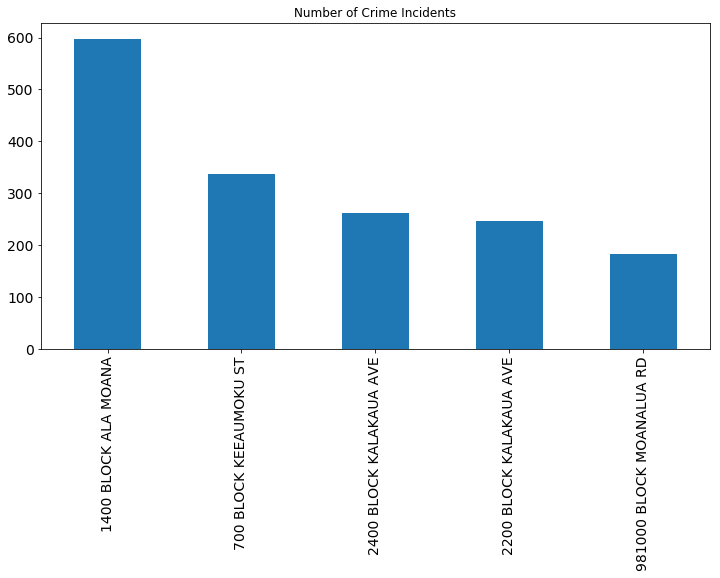

In [6]:
# Create a bar plot of the total number of incidents for each BlockAddress
df['BlockAddress'].value_counts().plot.bar(
    figsize=(12, 6),
    fontsize=14,
    title='Number of Crime Incidents'
)

#### Top 5 most occuring crime incident BlockAddresses
* The top 5 blocks with crime incidents are 1400 Ala Moana, 700 Keeaumokum, 2400 Kalakaua Ave, 2200 Kalakaua Ave, and 981000 Moanalua Rd.

* The most occuring BlockAddress is nearly double that of the second most occuring BlockAddress.

### Does time and side affect the number of crime incidents?

In [7]:
#Create new DataFrames that house only the data of a specific BlockAddress
df_alamoana = df_split[df_split['BlockAddress'] == '1400 BLOCK ALA MOANA'].copy()
df_keeaumoku = df_split[df_split['BlockAddress'] == '700 BLOCK KEEAUMOKU ST'].copy()
df_kalakaua2400 = df_split[df_split['BlockAddress'] == '2400 BLOCK KALAKAUA AVE'].copy()
df_kalakaua2200 = df_split[df_split['BlockAddress'] == '2200 BLOCK KALAKAUA AVE'].copy()
df_moanalua = df_split[df_split['BlockAddress'] == '981000 BLOCK MOANALUA RD'].copy()

# Prints out the number of incidents of each side for each BlockAddress
print('Alamoana\n',df_alamoana['Side'].value_counts(),'\n\n',
     'Keeaumoku\n',df_keeaumoku['Side'].value_counts(),'\n\n',
     '2400 Kalakaua\n',df_kalakaua2400['Side'].value_counts(),'\n\n',
     '2200 Kalakaua\n',df_kalakaua2200['Side'].value_counts(),'\n\n',
     'Moanalua\n',df_moanalua['Side'].value_counts(),'\n\n')

Alamoana
 L    597
R      1
Name: Side, dtype: int64 

 Keeaumoku
 L    323
R     14
Name: Side, dtype: int64 

 2400 Kalakaua
 R    153
L    110
Name: Side, dtype: int64 

 2200 Kalakaua
 R    187
L     60
Name: Side, dtype: int64 

 Moanalua
 R    164
L     20
Name: Side, dtype: int64 




In [8]:
# Index for new side DataFrame
side_index = ['Left', 'Right']

# Array containing data for number of left and right incidents [Left, Right]
alamoana_side = [597, 1]
keeaumoku_side = [323, 14]
kalakaua24_side = [110, 153]
kalakaua22_side = [60, 187]
moanalua_side = [20, 164]

# Creates a DataFrame using the above arrays
df_sides = pd.DataFrame({'1400 Alamoana': alamoana_side,
                        '700 Keeaumoku': keeaumoku_side,
                        '2400 Kalakaua': kalakaua24_side,
                        '2200 Kalakaua': kalakaua22_side,
                        '981000 Moanalua': moanalua_side},
                        index=side_index)

Text(0.5,1,'Number of Incidents per Side')

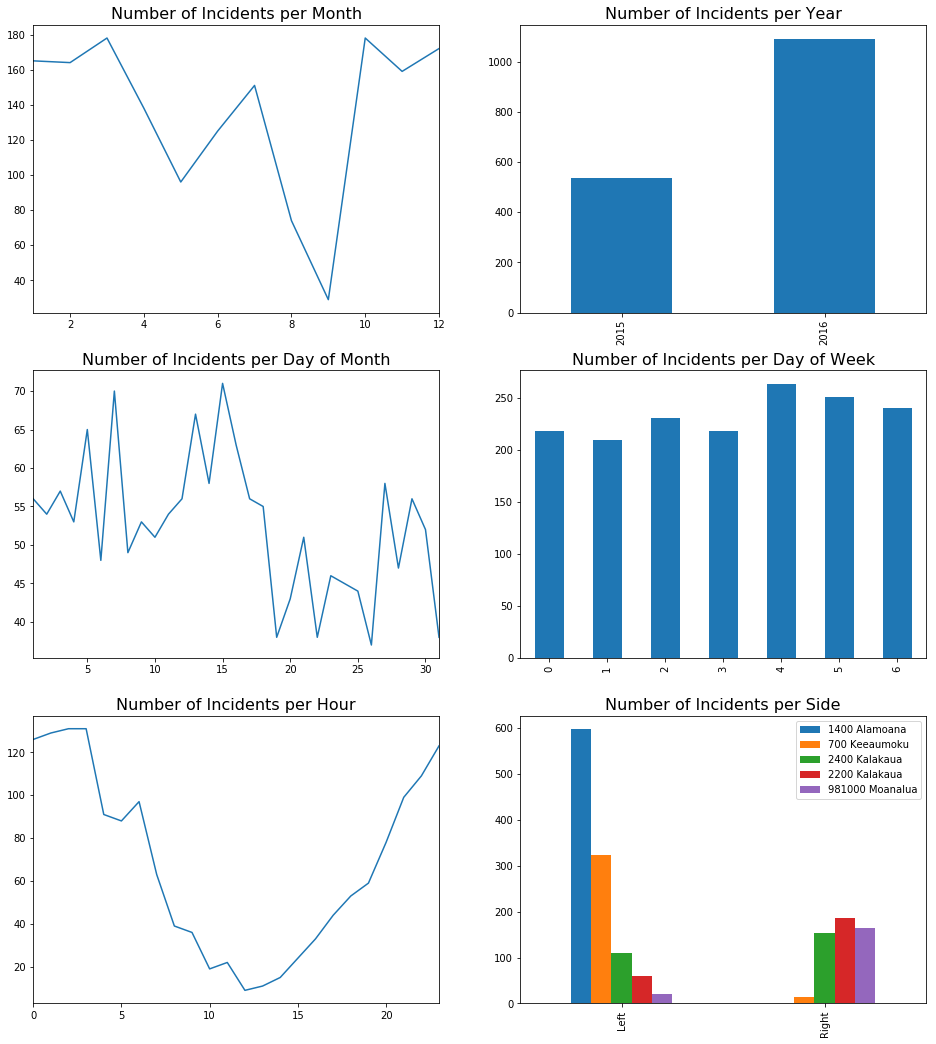

In [9]:
# Creating a subplot
fig, axarr = plt.subplots(3, 2, figsize=(16, 18))

# Line plot of number of incidents per Month(0-12)
df_split['Month'].value_counts().sort_index().plot.line(ax=axarr[0][0])

# Bar plot of number of incidents per Year(2015 & 2016)
df_split['Year'].value_counts().sort_index().plot.bar(ax=axarr[0][1])

# Line plot of number of incidents per Day of Month(0-31)
df_split['Day'].value_counts().sort_index().plot.line(ax=axarr[1][0])

# Bar plot of number of incidents per Day(0-6, 0=Sunday, 6=Saturday)
df_split['DayofWeek'].value_counts().sort_index().plot.bar(ax=axarr[1][1])

# Line plot of number of incidents per Hour(0 = midnight, 12 = midday)
df_split['Hour'].value_counts().sort_index().plot.line(ax=axarr[2][0])

# bar plot of number of incidents that occured on the left and right side for each block address
df_sides.plot.bar(ax=axarr[2][1])

# Adds title to each subplot
axarr[0][0].set_title("Number of Incidents per Month", fontsize=16)
axarr[0][1].set_title("Number of Incidents per Year", fontsize=16)
axarr[1][0].set_title("Number of Incidents per Day of Month", fontsize=16)
axarr[1][1].set_title("Number of Incidents per Day of Week", fontsize=16)
axarr[2][0].set_title("Number of Incidents per Hour", fontsize=16)
axarr[2][1].set_title("Number of Incidents per Side", fontsize=16)

#### Number of Incidents per Month
* Looking at the Number of Incidents per Month There are 2 steep valleys, one in May and September. However, the valley in September could be caused by the data of 2015 starts at September 24 and the data for 2016 ends at August 18. So the data in September is limited.

#### Nmber of Incidents per Year
* When comparing the number of incidents per Year the bar graph shows that the 2016 had more incidents, however, the 2015 data covers incidents from 9/24/15 - 12/31/15. Whereras the 2016 data covers incidents from 1/1/16-8/18/16, which could explain the difference being nearly double.

#### Number of Incidents per Day of Month
* The number of incidents per day of month peaks at the end of the first and second weeks of the month and then drop off and slowly rise back up. the dates X/16 - X/26 seems to be the dates where crime is least likely to happen.

#### Number of Incidents per Day of Week
* As for the days of the week Thursdays has the highest number of incidents, followed by Friday and Saturday for days of the week with the most occuring crime incidents.

#### Number of Incidents per Hour
* Number of crime incidents is at its lowest during the midday and increases to its peak 2 hours past midnight and then decreases until it reaches midday again.

#### Number of Inicidents per Side
* The number of crime incidents seems to favor one side, with the favored side having an overwhelming number of incidents over the other side. The only exception is 2400 Kalakaua block which has a about a 40/60 split.
* Nearly all of the Alamoana and Keeaumoku incidents occured on the left side.

### Do certain types of crime incidents happen more on a certain day and on a certain day of the month?

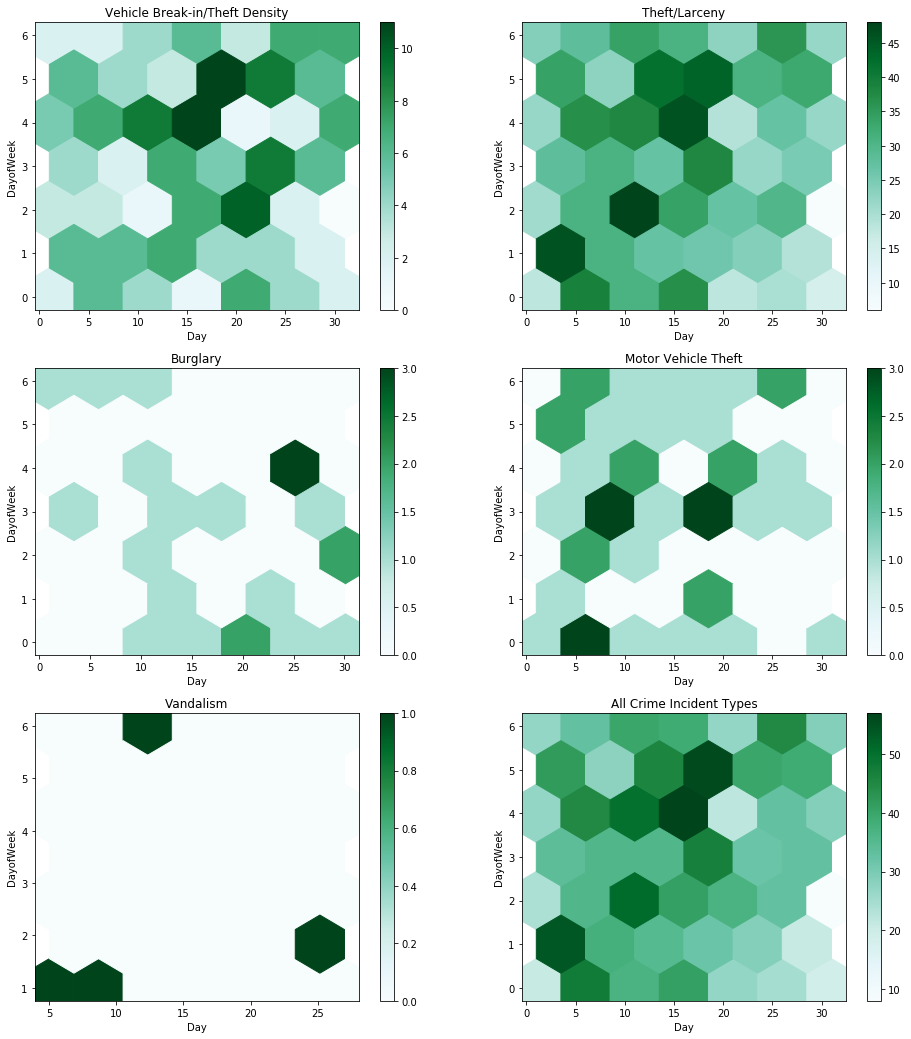

In [10]:
# Creates a subplot of 3 rows and 2 columns
fig, axarr = plt.subplots(3,2,figsize=(16,18))

# Hexbin plot of VEHICLE BREAK-IN/THEFT
df_split[df_split['Type'] == 'VEHICLE BREAK-IN/THEFT'].plot.hexbin(x='Day',
                                                                   y='DayofWeek',
                                                                   gridsize=6,
                                                                   title='Vehicle Break-in/Theft Density',
                                                                   ax=axarr[0][0]
                                                                  )
# Hexbin plot of THEFT/LARCENY
df_split[df_split['Type'] == 'THEFT/LARCENY'].plot.hexbin(x='Day',
                                                          y='DayofWeek',
                                                          gridsize=6,
                                                          title='Theft/Larceny',
                                                         ax=axarr[0][1])
# Hexbin plot of BURGLARY
df_split[df_split['Type'] == 'BURGLARY'].plot.hexbin(x='Day',
                                                          y='DayofWeek',
                                                          gridsize=6,
                                                          title='Burglary',
                                                         ax=axarr[1][0])
# Hexbin plot of MOTOR VEHICLE THEFT
df_split[df_split['Type'] == 'MOTOR VEHICLE THEFT'].plot.hexbin(x='Day',
                                                          y='DayofWeek',
                                                          gridsize=6,
                                                          title='Motor Vehicle Theft',
                                                         ax=axarr[1][1])
# Hexbin plot of VANDALISM
df_split[df_split['Type'] == 'VANDALISM'].plot.hexbin(x='Day',
                                                          y='DayofWeek',
                                                          gridsize=6,
                                                          title='Vandalism',
                                                         ax=axarr[2][0])
# Hexbin plot of all types
df_split.plot.hexbin(x='Day',
                     y='DayofWeek',
                     gridsize=6,
                     title='All Crime Incident Types',
                    ax=axarr[2][1])

#### Vehicle Break-in/Theft
* The darkest spots on the hexbin plot show that the most occuring days for vehicle break-in/theft are on Thursday and Friday around the middle of the month. The first half of the month is lighter tha n the second half of the month.

#### Theft/Larceny
* Theft/Larceny is the most occuring type of crime incident in Hawaii. So, the hexbin plot has less light spots than the other types. What can be seen is that most thefts/larceny incidents occur from day 5 to day 20 of a month and the least amount occurs in the beginning of the week at the end of the month.
* The darkest spots indicate that this type of incident is common on Mondays in the first week, Tuesdays on the second week, and Thurdays on the third week of the month.

#### Burglary
* Burglary is one of the least occuring incident type to occur in this data set, with only vandalism being less than it.
* From the hexbin plot it can be seen that the weekends are likely when it would happen.

#### Motor Vehicle Theft
* Motor vehicle thefts has many white spaces on Mondays and Tuesdays.
* The dark and lightly shaded spots show that the first week of the months is when this type of incident is likely to happen.

#### Vandalism
* Vandalism is the least likely occuring incident in this data set, when looking at the top 5 BlockAddresses, with only 4 vandalism incidents happening. Due to the lack of data there isn't much that can drawn from the plot.

#### All Crime Types
* The darkest spot in this plot is on a Thursday in the middle of the month followed by a Monday in the beginning of the month and Friday on the third week of a month.
* When looking at the hexbin plot a slight positive trend can be made out where the number of incidents start out more common in the beginning of the week and the beginning of the month then slowly transition to the end of the week by the end of the month.

### How does each BlockAddress compare to the others with incident count and types?

In [11]:
# Prints out the number of incidents of each type for each BlockAddress
print('Alamoana\n',df_alamoana['Type'].value_counts(),'\n\n',
     'Keeaumoku\n',df_keeaumoku['Type'].value_counts(),'\n\n',
     '2400 Kalakaua\n',df_kalakaua2400['Type'].value_counts(),'\n\n',
     '2200 Kalakaua\n',df_kalakaua2200['Type'].value_counts(),'\n\n',
     'Moanalua\n',df_moanalua['Type'].value_counts(),'\n\n')

Alamoana
 THEFT/LARCENY             474
VEHICLE BREAK-IN/THEFT     97
MOTOR VEHICLE THEFT        20
BURGLARY                    5
VANDALISM                   2
Name: Type, dtype: int64 

 Keeaumoku
 THEFT/LARCENY             278
VEHICLE BREAK-IN/THEFT     51
MOTOR VEHICLE THEFT         6
BURGLARY                    2
Name: Type, dtype: int64 

 2400 Kalakaua
 THEFT/LARCENY             249
VEHICLE BREAK-IN/THEFT     10
BURGLARY                    4
Name: Type, dtype: int64 

 2200 Kalakaua
 THEFT/LARCENY             226
VEHICLE BREAK-IN/THEFT     12
BURGLARY                    7
VANDALISM                   1
MOTOR VEHICLE THEFT         1
Name: Type, dtype: int64 

 Moanalua
 THEFT/LARCENY             108
VEHICLE BREAK-IN/THEFT     56
MOTOR VEHICLE THEFT        15
BURGLARY                    4
VANDALISM                   1
Name: Type, dtype: int64 




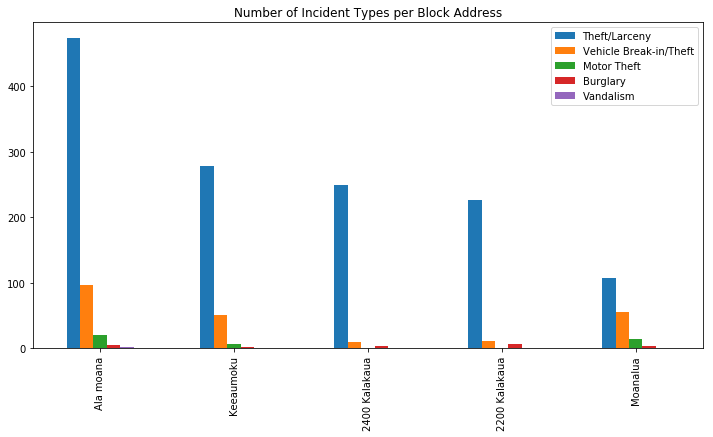

In [12]:
# Index for the bar plots
index = ['Ala moana', 'Keeaumoku', '2400 Kalakaua', '2200 Kalakaua', 'Moanalua']

# Arrays of number of incidents for each type [Alamoana, Keeaumoku, 2400 Kalakaua, 2200 Kalakaua, Moanalua]
vehicle_breakin = [97,51,10,12,56]
theft_larceny = [474,278,249,226,108]
burglary = [5,2,4,7,4]
motor_theft = [20,6,0,1,15]
vandalism = [2,0,0,1,1]

# Creates a DataFrame of the number arrays
df_types = pd.DataFrame({'Theft/Larceny': theft_larceny,
                         'Vehicle Break-in/Theft': vehicle_breakin,
                         'Motor Theft': motor_theft,
                         'Burglary': burglary,
                         'Vandalism': vandalism},
                         index=index)

# Bar plot of the DataFrame to compare each Type for each BlockAddress
df_types.plot.bar(figsize=(12,6),
                 title='Number of Incident Types per Block Address')

#### Number of Incident Types per BlockAddress
* In each BlockAddress it is can be seen that theft/larceny is the most occuring type.
* The next most occuring type is vehicle break-in/theft.

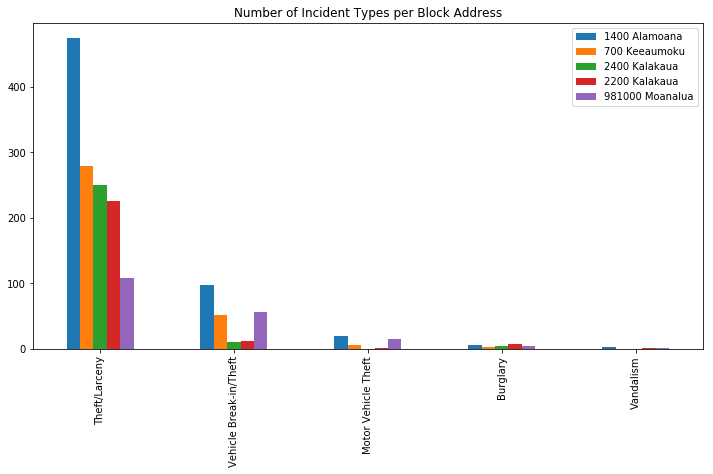

In [13]:
# Index of Number of Incident Types per Block Address bar plot
index = ['Theft/Larceny', 'Vehicle Break-in/Theft', 'Motor Vehicle Theft', 'Burglary', 'Vandalism']

# Arrays containing number of incident type counts
# [Theft/Larceny, Vehicle Break-in/Theft, Motor Vehicle Theft, Burglary, Vandalism]
alam = [474,97,20,5,2]
keea = [278,51,6,2,0]
kala24 = [249,10,0,4,0]
kala22 = [226,12,1,7,1]
moana = [108,56,15,4,1]

# Creates a DataFrame using the above arrays
df_types = pd.DataFrame({'1400 Alamoana': alam,
                        '700 Keeaumoku': keea,
                        '2400 Kalakaua': kala24,
                        '2200 Kalakaua': kala22,
                        '981000 Moanalua': moana},
                        index=index)
# Bar plot of the DataFrame to compare each AddressBlock for each Type
df_types.plot.bar(figsize=(12,6),
                 title='Number of Incident Types per Block Address')

#### Number of incident types per BlockAddress
* The Alamoana BlockAddress has the highest incident count for all types compared to the other BlockAddresses.
* Although the Moanalua Rd block has the least amount of incidents overall, it has the second most vehicle break-in/theft incidents.

## Machine Learning Model Building

The goal is to have a model predict the type of incident that can occur given the features BlockAddress and Date. The problem seems like a classification one so, a Support Vector Machine was choosen for this task.

In [14]:
# Array of features
crime_data_features = ['BlockAddress', 'Month', 'Day', 'Year', 'DayofWeek', 'Hour', 'Minutes', 'Side']

X = df_split[crime_data_features]
y = df_split.Type

### Label Encoding Support Vector Machine

In [15]:
# Train and test split of data with 20% of the data as test data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=0)

# creating a list of object dtypes in X
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# Copying data from X_train and X_valid for label encoding
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

label_encoder = LabelEncoder()

# Label encoding the Object columns
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])

#svclassifier = SVC(kernel='poly', degree=2)
# Support Vector Machine, with the Gaussian kernel
svclassifier = SVC(C=2.0, kernel='rbf')
svclassifier.fit(label_X_train, y_train)

y_pred = svclassifier.predict(label_X_valid)

# Print out the evaluation of the model with a confusion matrix
print(confusion_matrix(y_valid, y_pred))
print(classification_report(y_valid, y_pred))
print('Cross Validation Score with 5 folds:',cross_val_score(svclassifier, label_X_train, y_train, cv=5))

[[  0   0   8   0   0]
 [  0   0  19   0   0]
 [  0   0 521   0   3]
 [  0   0   1   0   0]
 [  0   0  98   0   2]]
                        precision    recall  f1-score   support

              BURGLARY       0.00      0.00      0.00         8
   MOTOR VEHICLE THEFT       0.00      0.00      0.00        19
         THEFT/LARCENY       0.81      0.99      0.89       524
             VANDALISM       0.00      0.00      0.00         1
VEHICLE BREAK-IN/THEFT       0.40      0.02      0.04       100

           avg / total       0.71      0.80      0.72       652

Cross Validation Score with 5 folds: [0.82323232 0.82142857 0.81632653 0.81958763 0.83419689]


#### Label Encoding Results
* The confusion matrix shows that there were Burglary, Motor Vehicle Theft, and Vandalism were never correctly predicted.
* Theft/Larceny had 3 mispredictions and Vehicle Break-in/Theft had only 2 correct predictions out of 100.
* The highest score achieved from the cross validation with 5 folds was about .8342. However, this high score could have just been due to the overwhelming amount of Theft/Larceny incidents in the data.

### One-Hot and Label Encoding Support Vector Machine

In [16]:
# One-Hot Encode the training and test data, that was already one label endoded
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(label_X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(label_X_valid[object_cols]))

# Add the index back as one-hot encoding removed the index
OH_cols_train.index = label_X_train.index
OH_cols_valid.index = label_X_valid.index

# Getting the non-object columns
num_X_train = label_X_train.drop(object_cols, axis=1)
num_X_valid = label_X_valid.drop(object_cols, axis=1)

# Combining the one-hot encoded columns to the non-object columns
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# Training and predict with Support Vector Machine
svclassifier.fit(OH_X_train, y_train)
OH_y_pred = svclassifier.predict(OH_X_valid)

# Evaluation with a confusion matrix, classification report and accuracy with 5 folds
print(confusion_matrix(y_valid, OH_y_pred))
print(classification_report(y_valid, OH_y_pred))
print('Cross Validation Score with 5 folds:',cross_val_score(svclassifier, OH_X_train, y_train, cv=5))

[[  0   0   8   0   0]
 [  0   0  19   0   0]
 [  0   0 517   0   7]
 [  0   0   1   0   0]
 [  0   1  96   0   3]]
                        precision    recall  f1-score   support

              BURGLARY       0.00      0.00      0.00         8
   MOTOR VEHICLE THEFT       0.00      0.00      0.00        19
         THEFT/LARCENY       0.81      0.99      0.89       524
             VANDALISM       0.00      0.00      0.00         1
VEHICLE BREAK-IN/THEFT       0.30      0.03      0.05       100

           avg / total       0.69      0.80      0.72       652

Cross Validation Score with 5 folds: [0.81818182 0.80612245 0.79081633 0.81958763 0.8238342 ]


#### One-Hot and Label Encoding Results
* The confusion matrix shows that compared to just having One Label Encoding, the addition of One-Hot Encoding decreased the accuracy of the model slightly as it made a handful more mistakes for Theft/Larceny and Vehicle Break-in/Theft.
* The other 3 types of incidents remained with zero predictions.
* The highest score achieved from this model using a cross validation of 5 folds is about .8238.

## Conclusion
In conclusion, the Support Vector Machine model was able to predict the type of crime incident to occur with 83% accuracy when looking at crime incidents of the top 5 most occuring block addresses. However, this accuracy is due to a vast majority of the data falling into one type of crime incident, theft/larceny. The other types of crime incidents were either never predicted or only predicted a couple of times correctly.

I think what could have made this model more accurate would have been more burglary, motor vehicle theft, vandalism, and vehicle break-in/theft entries. However, this wouldn't be good for the public safety of Hawaii. I think an alternative could be more features that can possibly help the model to predict the type of crime incident to occur. Additional features could be type of vehicle and possibly longitude and latitude values to pinpoint location instead of a general block address.

In [21]:
weather_file_path = 'https://raw.githubusercontent.com/garywhi/CrimeIncidents/weather/weather.csv'
weather_data = pd.read_csv(weather_file_path)
weather_df = pd.DataFrame(data=weather_data)
weather_df.describe(include='all')

,STATION,NAME,DATE,AWND,PGTM,TAVG,TMAX,TMIN,TOBS,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT08,WT10
count,56195,56195,56195,2751.000000,175.000000,9042.000000,19510.000000,19428.000000,8100.000000,2753.000000,2620.000000,2753.000000,2620.000000,688.0,2.0,18.0,286.0,2.0
unique,229,229,343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,USC00513910,"CAMPBELL IN PK 702.5, HI US",2016-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,343,343,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.343526,1333.097143,70.252820,78.831830,64.567068,70.276790,106.306575,102.916031,18.254268,24.694122,1.0,1.0,1.0,1.0,1.0
std,NaN,NaN,NaN,3.991868,545.971839,7.546399,7.196478,9.512668,7.915215,94.338866,92.689486,5.488116,6.870612,0.0,0.0,0.0,0.0,0.0
min,NaN,NaN,NaN,2.010000,1.000000,44.000000,45.000000,-32.000000,7.000000,10.000000,10.000000,4.900000,8.900000,1.0,1.0,1.0,1.0,1.0
25%,NaN,NaN,NaN,6.260000,1048.000000,66.000000,76.000000,61.000000,66.000000,40.000000,40.000000,14.100000,19.900000,1.0,1.0,1.0,1.0,1.0
50%,NaN,NaN,NaN,8.280000,1405.000000,72.000000,80.000000,67.000000,72.000000,60.000000,60.000000,17.000000,23.900000,1.0,1.0,1.0,1.0,1.0
75%,NaN,NaN,NaN,12.080000,1635.000000,76.000000,84.000000,71.000000,76.000000,140.000000,130.000000,21.900000,30.000000,1.0,1.0,1.0,1.0,1.0
